# Recurrent Neural Networks - Character level language model



Welcome to Dinosaurus Island! 65 million years ago, dinosaurs existed, and in this assignment they are back. You are in charge of a special task. Leading biology researchers are creating new breeds of dinosaurs and bringing them to life on earth, and your job is to give names to these dinosaurs. If a dinosaur does not like its name, it might go beserk, so choose wisely! 

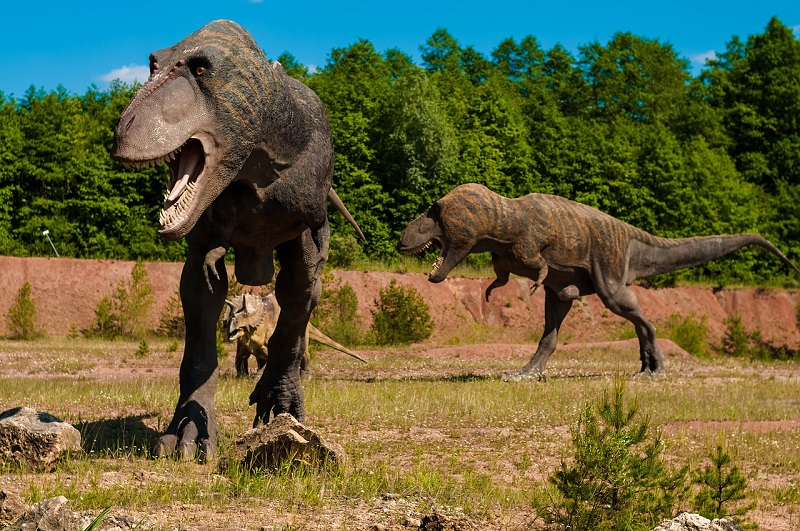

Luckily you have learned some deep learning and you will use it to save the day. Your assistant has collected a list of all the dinosaur names they could find, and compiled them into dataset(dinos.txt). To create new dinosaur names, you will build a character level language model to generate new names. Your algorithm will learn the different name patterns, and randomly generate new names. Hopefully this algorithm will keep you and your team safe from the dinosaurs' wrath! 


- How to store text data for processing using an RNN 
- How to synthesize data, by sampling predictions at each time step and passing it to the next RNN-cell unit
- How to build a character-level text generation recurrent neural network
- Why clipping the gradients is important

We will begin by loading in some functions that we have provided for you in `rnn_utils`. Specifically, you have access to functions such as `rnn_forward` and `rnn_backward` which are equivalent to those you've implemented in the previous assignment. 

# Problem Statement

### Dataset and Preprocessing

Run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size. 

In [1]:
import numpy as np
import random

In [2]:
# Build list of all dinosaur names (training examples).
with open("../input/RnnDS/dinos.txt") as f:
    examples = f.readlines()
examples = [x.lower().strip() for x in examples]

In [3]:
print(examples[0:5])

['aachenosaurus', 'aardonyx', 'abdallahsaurus', 'abelisaurus', 'abrictosaurus']


### Distinct Chars

In [4]:
data = open('../input/RnnDS/dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
print(sorted(chars))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
There are 19909 total characters and 27 unique characters in your data.


The characters are a-z (26 characters) plus the "\n" (or newline character), which in this assignment plays a role similar to the `<EOS>` (or "End of sentence") token we had discussed in lecture, only here it indicates the end of the dinosaur name rather than the end of a sentence. In the cell below, we create a python dictionary (i.e., a hash table) to map each character to an index from 0-26. We also create a second python dictionary that maps each index back to the corresponding character character. This will help you figure out what index corresponds to what character in the probability distribution output of the softmax layer. Below, `char_to_ix` and `ix_to_char` are the python dictionaries. 

In [5]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
print('ix_to_char =',ix_to_char,'\n\nchar_to_ix =',char_to_ix)

ix_to_char = {0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'} 

char_to_ix = {'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


### Overview of the model

Your model will have the following structure: 

- Initialize parameters 
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update your parameter with the gradient descent update rule.
- Return the learned parameters 
    

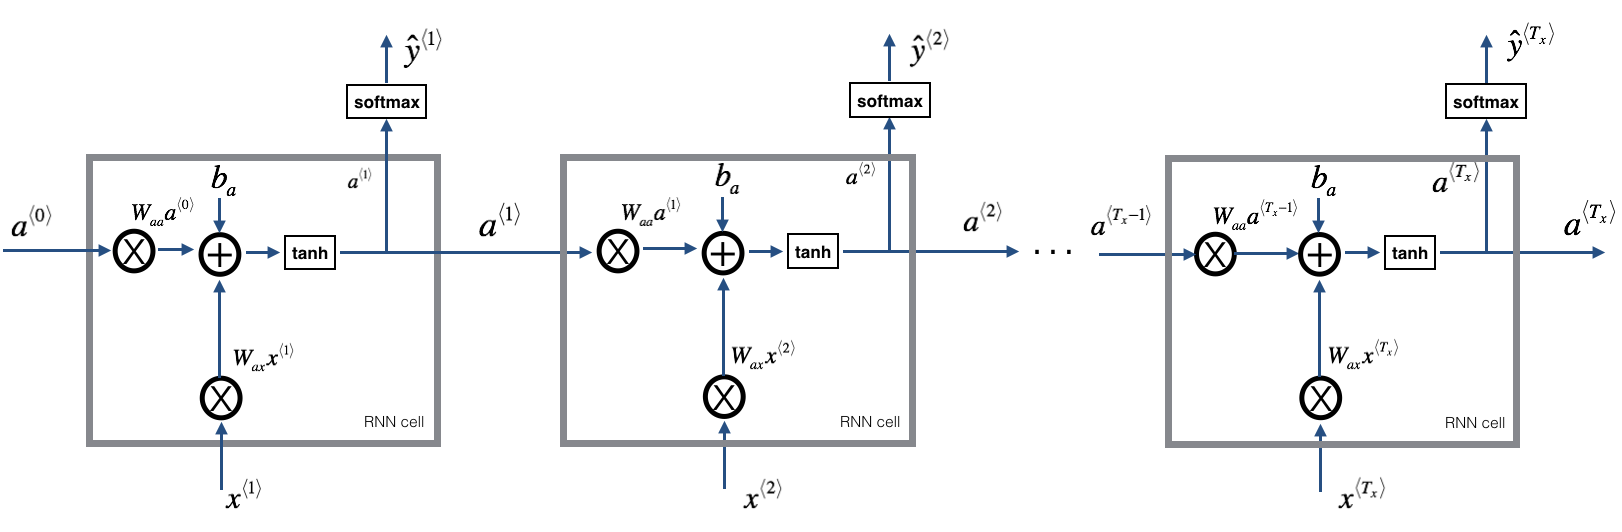

At each time-step, the RNN tries to predict what is the next character given the previous characters. The dataset $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters in the training set, while $Y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is such that at every time-step $t$, we have $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$. 

# Building the language model 

It is time to build the character-level language model for text generation. 

### Helper Functions

In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


## Initalize

functions: 
"""
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """

In [7]:
def initialize_parameters(inputLayerSize, hiddenLayerSize,  outputLayerSize):
    n_x,n_a, n_y=inputLayerSize, hiddenLayerSize,  outputLayerSize
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

### Gradient descent 

Function performing one step of **stochastic gradient descent (with clipped gradients)**. It will go through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent. As a reminder, here are the steps of a common optimization loop for an RNN:

- Forward propagate through the RNN to compute the loss
- Backward propagate through time to compute the gradients of the loss with respect to the parameters
- Clip the gradients if necessary 
- Update your parameters using gradient descent 

## Farword Propagation

In [8]:

def rnn_forward(X, Y, a0, parameters, vocab_size = 27):
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):
        
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector. 
        x[t] = np.zeros((vocab_size,1)) 
        if (X[t] != None):
            x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
    cache = (y_hat, a, x)
        
    return loss, cache

def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) # hidden state
    y_hat = softmax(np.dot(Wya, a_next) + by) # unnormalized log probabilities for next chars # probabilities for next chars 
    
    return a_next, y_hat




## Backward Propagation

In [9]:
   

    
def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    

    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])

    
    return gradients, a
def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] # backprop into h
    daraw = (1 - a * a) * da # backprop through tanh nonlinearity
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients

## Update Parameters

In [10]:
def update_parameters(parameters, gradients, lr):

    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    return parameters

## Clipping the gradients in the optimization loop

In this section you will implement the `clip` function that you will call inside of your optimization loop. Recall that your overall loop structure usually consists of a forward pass, a cost computation, a backward pass, and a parameter update. Before updating the parameters, you will perform gradient clipping when needed to make sure that your gradients are not "exploding," meaning taking on overly large values. 

In the exercise below, you will implement a function `clip` that takes in a dictionary of gradients and returns a clipped version of gradients if needed. There are different ways to clip gradients; we will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to lie between some range [-N, N]. More generally, you will provide a `maxValue` (say 10). In this example, if any component of the gradient vector is greater than 10, it would be set to 10; and if any component of the gradient vector is less than -10, it would be set to -10. If it is between -10 and 10, it is left alone. 

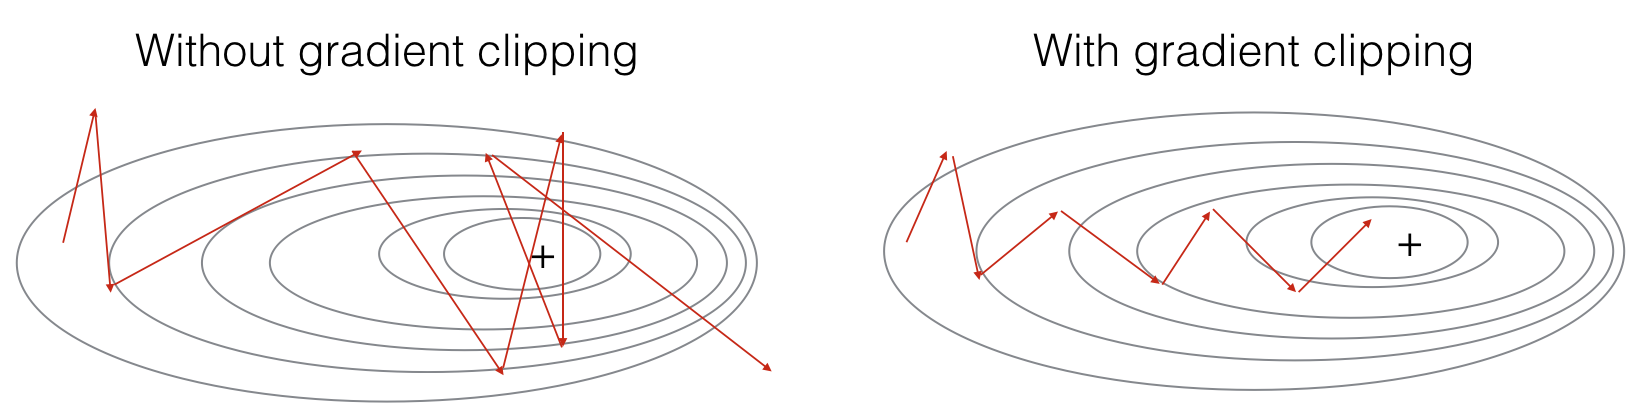

In [11]:
def clip(gradients, maxValue):

    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']
   
    # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]. 
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out=gradient)
    
    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
    return gradients

## One step of the optimization


   
    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.
    
    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)


In [12]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    
    
    # Forward propagate through time 
    loss, cache = rnn_forward(X, Y, a_prev, parameters)
    
    # Backpropagate through time (≈1 line)
    gradients, a = rnn_backward(X, Y, parameters, cache)
    
    # Clip your gradients between -5 (min) and 5 (max) 
    gradients = clip(gradients, maxValue=5)
    
    # Update parameters (≈1 line)
    parameters = update_parameters(parameters, gradients, learning_rate)
    
   
    
    return loss, gradients, a[len(X)-1]

# Training the model 

Given the dataset of dinosaur names, we use each line of the dataset (one name) as one training example. Every 100 steps of stochastic gradient descent, you will sample 10 randomly chosen names to see how the algorithm is doing. Remember to shuffle the dataset, so that stochastic gradient descent visits the examples in random order. 

**Exercise**: Follow the instructions and implement `model()`. When `examples[index]` contains one dinosaur name (string), to create an example (X, Y), you can use this:
```python
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
```
Note that we use: `index= j % len(examples)`, where `j = 1....num_iterations`, to make sure that `examples[index]` is always a valid statement (`index` is smaller than `len(examples)`).
The first entry of `X` being `None` will be interpreted by `rnn_forward()` as setting $x^{\langle 0 \rangle} = \vec{0}$. Further, this ensures that `Y` is equal to `X` but shifted one step to the left, and with an additional "\n" appended to signify the end of the dinosaur name. 

"""
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data -- text corpus
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text, size of the vocabulary
    
    Returns:
    parameters -- learned parameters
    """

In [18]:
def model(examples, ix_to_char, char_to_ix, num_iterations = 35000, hiddenLayerSize = 50, vocab_size = 27):
    
    
    # Retrieve n_x and n_y from vocab_size
    inputLayerSize, outputLayerSize = vocab_size, vocab_size
    
    
    # Initialize parameters
    parameters = initialize_parameters(inputLayerSize, hiddenLayerSize,  outputLayerSize)
    
    # Initialize loss (this is required because we want to smooth our loss, don't worry about it)
    loss = -np.log(1.0/vocab_size)
    
    
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((hiddenLayerSize, 1))
    
    # Optimization loop
    #for j in range(num_iterations):
    for j in range(1):    
       
        
        # Use the hint above to define one training example (X,Y) (≈ 2 lines)
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]] 
        Y = X[1:] + [char_to_ix["\n"]]
        print(X,Y)
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
        
     

        
        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = loss * 0.999 + curr_loss * 0.001

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if (j+1) % 5000 == 0:
            print('Iteration: %d, Loss: %f' % (j+1, loss) )
        
    return parameters

Run the following cell, you should observe your model outputting random-looking characters at the first iteration. After a few thousand iterations, your model should learn to generate reasonable-looking names. 

In [19]:
parameters = model(examples, ix_to_char, char_to_ix)

27 50 27
[None, 22, 5, 12, 15, 3, 9, 18, 1, 16, 20, 15, 18] [22, 5, 12, 15, 3, 9, 18, 1, 16, 20, 15, 18, 0]


# Sampling

Now assume that your model is trained. You would like to generate new text (characters). The process of generation is explained in the picture below:

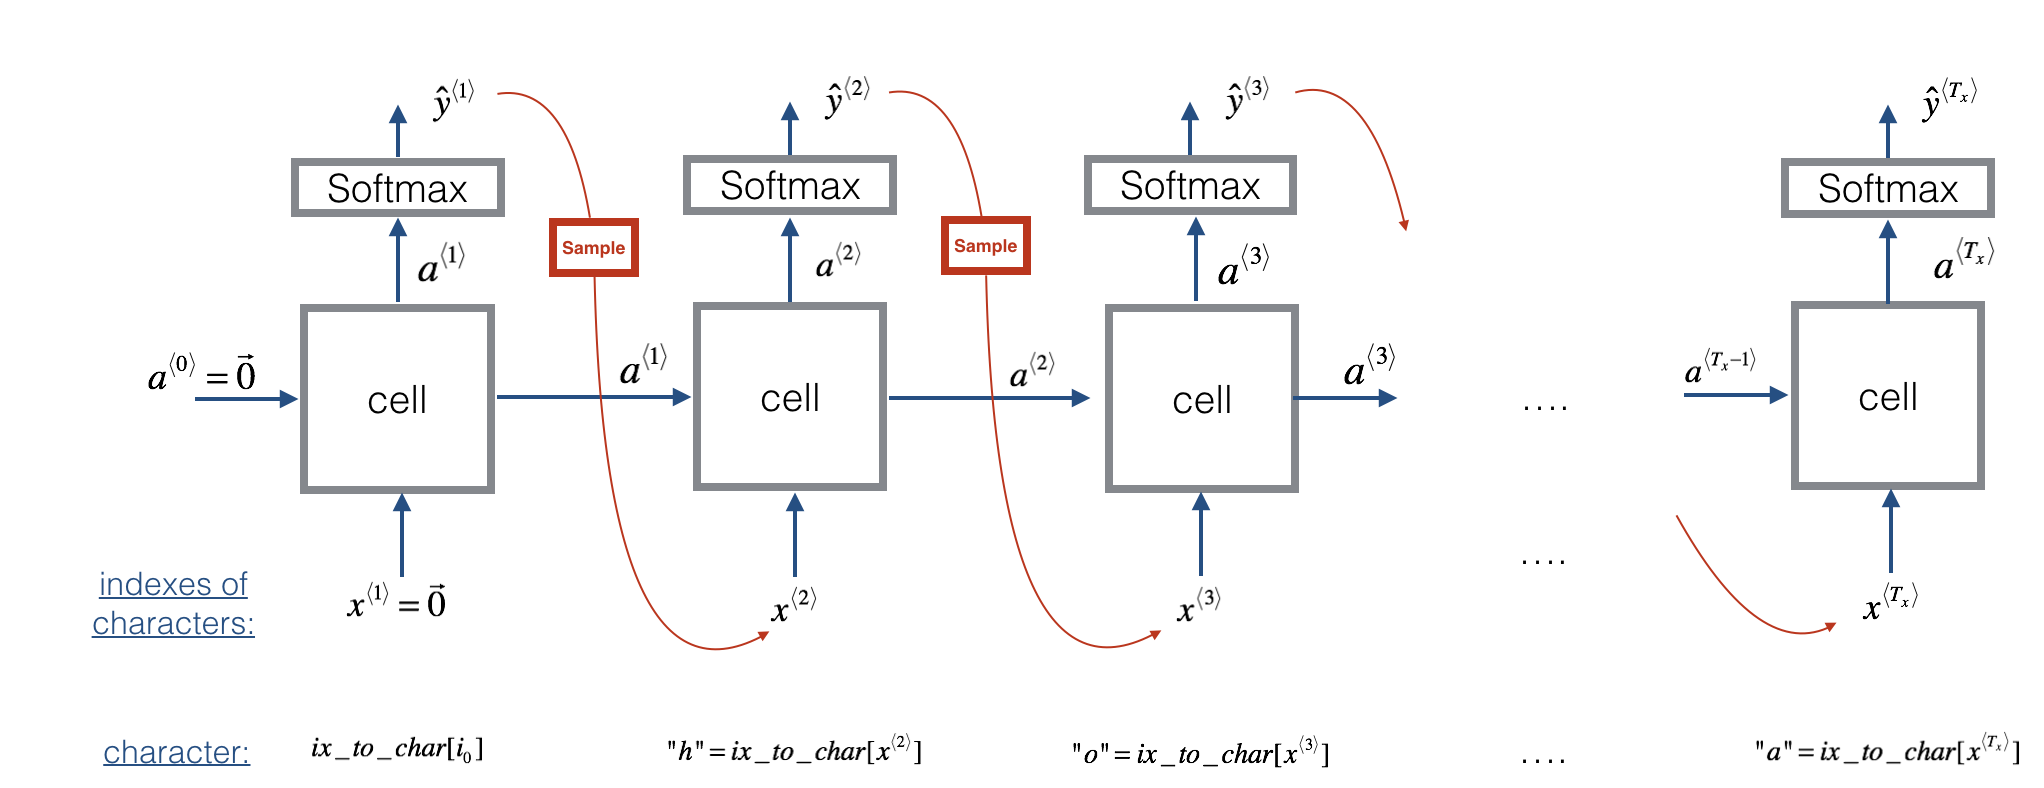

 Implementing the `sample` function below to sample characters. You need to carry out 4 steps:

- **Step 1**: Pass the network the first "dummy" input $x^{\langle 1 \rangle} = \vec{0}$ (the vector of zeros). This is the default input before we've generated any characters. We also set $a^{\langle 0 \rangle} = \vec{0}$

- **Step 2**: Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here are the equations:

$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$

$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$

$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$

Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.  We have provided a `softmax()` function that you can use.

- **Step 3**: Carry out sampling: Pick the next character's index according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$. This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, you will pick the index "i" with 16% probability. To implement it, you can use [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.choice.html).

Here is an example of how to use `np.random.choice()`:
```python
np.random.seed(0)
p = np.array([0.1, 0.0, 0.7, 0.2])
index = np.random.choice([0, 1, 2, 3], p = p.ravel())
```
This means that you will pick the `index` according to the distribution: 
$P(index = 0) = 0.1, P(index = 1) = 0.0, P(index = 2) = 0.7, P(index = 3) = 0.2$.

- **Step 4**: The last step to implement in `sample()` is to overwrite the variable `x`, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. You will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character you've chosen as your prediction. You will then forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until you get a "\n" character, indicating you've reached the end of the dinosaur name. 


"""
    
    
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- python dictionary containing the parameters Waa, Wax, Wya, by, and b. 
    char_to_ix -- python dictionary mapping each character to an index.
    seed -- used for grading purposes. Do not worry about it.

    Returns:
    indices -- a list of length n containing the indices of the sampled characters.
    """

In [18]:
def sample(parameters, char_to_ix, seed):
 
    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    # Step 1: Create the one-hot vector x for the first character (initializing the sequence generation). (≈1 line)
    x = np.zeros((vocab_size, 1))
    # Step 1': Initialize a_prev as zeros (≈1 line)
    a_prev = np.zeros((n_a, 1))
    
    # Create an empty list of indices, this is the list which will contain the list of indices of the characters to generate (≈1 line)
    indices = []
    
    # Idx is a flag to detect a newline character, we initialize it to -1
    idx = -1 
    
    # Loop over time-steps t. At each time-step, sample a character from a probability distribution and append 
    # its index to "indices". We'll stop if we reach 50 characters (which should be very unlikely with a well 
    # trained model), which helps debugging and prevents entering an infinite loop. 
    counter = 0
    newline_character = char_to_ix['\n']
    
    while (idx != newline_character and counter != 50):
        
        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        
        # for grading purposes
        np.random.seed(counter+seed) 
        
        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        idx = np.random.choice(list(range(vocab_size)), p = y.ravel())

        # Append the index to "indices"
        indices.append(idx)
        
        # Step 4: Overwrite the input character as the one corresponding to the sampled index.
        x = np.zeros((vocab_size, 1))
        x[idx] = 1
        
        # Update "a_prev" to be "a"
        a_prev = a
        
        # for grading purposes
        seed += 1
        counter +=1

    if (counter == 50):
        indices.append(char_to_ix['\n'])
    
    return indices

## Convert index to char and char to word

In [19]:
def print_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    print ('%s' % (txt, ), end='')

## Run Sampling

In [22]:
# The number of dinosaur names to print
seed = 0
sampleCount=7
for name in range(sampleCount):

    # Sample indices and print them
    sampled_indices = sample(parameters, char_to_ix, seed)
    print_sample(sampled_indices, ix_to_char)

    seed += 1  # To get the same result for grading purposed, increment the seed by one. 


Piutysaurus
Migaaeosaurus
Mutrodonspexdshuaonngus
Pacaepsaurus
Yusoenatonacorsaurus
Gaaeron
Trucilnlithus


## Conclusion

You can see that your algorithm has started to generate plausible dinosaur names towards the end of the training. At first, it was generating random characters, but towards the end you could see dinosaur names with cool endings. Feel free to run the algorithm even longer and play with hyperparameters to see if you can get even better results. Our implemetation generated some really cool names like `maconucon`, `marloralus` and `macingsersaurus`. Your model hopefully also learned that dinosaur names tend to end in `saurus`, `don`, `aura`, `tor`, etc.

If your model generates some non-cool names, don't blame the model entirely--not all actual dinosaur names sound cool. (For example, `dromaeosauroides` is an actual dinosaur name and is in the training set.) But this model should give you a set of candidates from which you can pick the coolest! 

This is relatively small dataset, so that you could train an RNN quickly on a CPU. Training a model of the english language requires a much bigger dataset, and usually needs much more computation, and could run for many hours on GPUs.